In [17]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
from collections import Counter



## Data Preparations


In [3]:
#read csv(s)
movies_df = pd.read_csv("dataset/small_dataset/movies_full_2.csv")
ratings_df = pd.read_csv("dataset/small_dataset/ratings.csv")
tags_df = pd.read_csv("dataset/small_dataset/tags.csv")
links_df = pd.read_csv("dataset/small_dataset/links.csv")


In [4]:
# print(ratings_df.duplicated)
# print(ratings_df.shape)
# print(ratings_df['userId'].nunique())

In [5]:
#drop timestamp as it is only consuming memory
ratings_df.drop('timestamp', axis=1, inplace=True)
tags_df.drop('timestamp', axis=1, inplace=True)


In [6]:

print(movies_df.isnull().sum())
movies_df['genres'] = movies_df['genres'].str.split('|')

movies_df.head()


movieId        0
title          0
genres         0
imdbId         0
year           0
url           18
titleLower     0
dtype: int64


,movieId,title,genres,imdbId,year,url,titleLower
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",tt0114709,1995.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,toy story
1,2,Jumanji,"[Adventure, Children, Fantasy]",tt0113497,1995.0,https://m.media-amazon.com/images/M/MV5BZTk2Zm...,jumanji
2,3,Grumpier Old Men,"[Comedy, Romance]",tt0113228,1995.0,https://m.media-amazon.com/images/M/MV5BMjQxM2...,grumpier old men
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",tt0114885,1995.0,https://m.media-amazon.com/images/M/MV5BYzcyMD...,waiting to exhale
4,5,Father of the Bride Part II,[Comedy],tt0113041,1995.0,https://m.media-amazon.com/images/M/MV5BOTEyNz...,father of the bride part ii


In [7]:
print(ratings_df.isnull().sum())
ratings_df.head()

userId     0
movieId    0
rating     0
dtype: int64


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [8]:
#print(tags_df.isnull().sum()) #It has 16 null tags
#print(tags_df[tags_df['tag'].isnull()].iloc[0])
tags_df.dropna(inplace=True)
print(tags_df.isnull().sum())
tags_df.head()

userId     0
movieId    0
tag        0
dtype: int64


,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [9]:
print(links_df.isnull().sum())
links_df.head()

movieId    0
imdbId     0
tmdbId     8
dtype: int64


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
movies_rating_user_df = pd.merge(movies_df, ratings_df, on="movieId", how="inner")
movies_rating_user_df.head()

,movieId,title,genres,imdbId,year,url,titleLower,userId,rating
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",tt0114709,1995.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,toy story,1,4.0
1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",tt0114709,1995.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,toy story,5,4.0
2,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",tt0114709,1995.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,toy story,7,4.5
3,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",tt0114709,1995.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,toy story,15,2.5
4,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",tt0114709,1995.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,toy story,17,4.5


In [11]:
movies_rating_df = movies_rating_user_df[['movieId', 'title', 'rating']].groupby(['movieId', 'title'])['rating'].agg(['count', 'mean']).round(1)


In [12]:
movies_rating_df.sort_values('count', ascending=False, inplace=True)
movies_rating_df.rename(columns={'count' : 'Num_ratings', 'mean': 'Average_rating'}, inplace=True)
movies_rating_df.head(15)

,,Num_ratings,Average_rating
movieId,title,,
356,Forrest Gump,329,4.2
318,"Shawshank Redemption, The",317,4.4
296,Pulp Fiction,307,4.2
593,"Silence of the Lambs, The",279,4.2
2571,"Matrix, The",278,4.2
260,Star Wars: Episode IV - A New Hope,251,4.2
480,Jurassic Park,238,3.8
110,Braveheart,237,4.0
589,Terminator 2: Judgment Day,224,4.0


# Data Preprocessing

In [13]:
#let's use the beysian average to calculate a more accurate rating
#this is because a review of 5 with only 1 review is worthless, while a 4.2 with multiple reviews is more reliable

def calculate_weighted_rating(df, C, m):
    """
    Calculate Bayesian weighted rating for each movie in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing movie ratings.
    C (float): Average rating across all movies (prior assumption).
    m (int): Minimum number of ratings required to be considered.

    Returns:
    DataFrame: DataFrame with Bayesian weighted rating column added.
    """
    
    # Add the Bayesian weighted rating as a new column in the DataFrame
    df['Bayesian_rating'] = (df['Num_ratings'] / (df['Num_ratings'] + m)) * df['Average_rating'] + (m / (df['Num_ratings'] + m)) * C

    return df

C = round(ratings_df['rating'].mean(), 2)
movies_rating_df = calculate_weighted_rating(movies_rating_df, C, 500)
movies_rating_df.drop(columns='Average_rating', inplace=True)
movies_rating_df.sort_values(by='Bayesian_rating', ascending=False, inplace=True)
movies_rating_df.head()

,,Num_ratings,Bayesian_rating
movieId,title,,
318,"Shawshank Redemption, The",317,3.849204
356,Forrest Gump,329,3.777805
296,Pulp Fiction,307,3.766295
593,"Silence of the Lambs, The",279,3.750706
2571,"Matrix, The",278,3.750129


# Recommendation System



### Content-based with just genres as the criteria

In [65]:
def bayesian_rating(r, v, m, c):
    return (v / (v + m) * r) + (m / (v + m) * c)

def recommend_movies_based_on_genres_user_based(user_id, df, top_n=10):
    # Filter ratings by the user
    user_ratings = df[df['userId'] == user_id]

    # Split genres into separate rows
    user_ratings_genres = user_ratings.assign(genres=user_ratings['genres']).explode('genres')

    # # Calculate average rating per genre
    genre_preferences = user_ratings_genres.groupby('genres')['rating'].mean().reset_index()
    
    genre_preferences = genre_preferences.sort_values(by='rating', ascending=False)
    
    #Get top genres
    top_genres = genre_preferences['genres'].head(3).tolist()  # Adjust number of top genres as needed
    print(top_genres)

    movie_ids_to_remove = user_ratings['movieId'].tolist() # list with movie ids that have to be removed as the user has already seen/rated them
    

     # Filter movies by top genres
    recommended_movies = df[df['genres'].apply(lambda x: any(genre in x for genre in top_genres))]

    # Further exclude movies in the provided list to remove
    recommended_movies = recommended_movies[~recommended_movies['movieId'].isin(movie_ids_to_remove)]

    # Calculate the mean rating across all movies
    C = recommended_movies['rating'].mean()
    # Set the minimum number of ratings required to be considered
    m = recommended_movies['movieId'].value_counts().quantile(0.75)

    # Group by movie and calculate Bayesian rating
    movie_stats = recommended_movies.groupby('movieId').agg({
        'title': 'first',
        'genres': 'first',
        'year': 'first',
        'rating': ['mean', 'count']
    }).reset_index()
    movie_stats.columns = ['movieId', 'title', 'genres', 'year', 'avg_rating', 'num_ratings']

    # Calculate the Bayesian rating
    movie_stats['bayesian_rating'] = movie_stats.apply(lambda x: bayesian_rating(x['avg_rating'], x['num_ratings'], m, C), axis=1)

    # Sort movies by Bayesian rating
    movie_recommendations = movie_stats.sort_values(by='bayesian_rating', ascending=False)
    movie_recommendations = movie_recommendations[['movieId', 'title', 'genres']]

    
    
    
    # Rank movies by overall rating
    # movie_recommendations = recommended_movies.groupby(['movieId', 'title', 'genres', 'year'])['rating'].mean().reset_index()
    # movie_recommendations = movie_recommendations.sort_values(by='rating', ascending=False)
    

    return movie_recommendations.head(top_n)

# Example usage
user_id = 1
top_n = 10
recommendations = recommend_movies_based_on_genres(user_id, movies_rating_user_df, top_n)
print(recommendations)


['Thriller', 'Romance', 'Action']
       movieId                                          title  \
15026   170705                              Band of Brothers    
26          50                           Usual Suspects, The    
793       2019          Seven Samurai (Shichinin no samurai)    
360        904                                   Rear Window    
1164      2959                                    Fight Club    
367        912                                    Casablanca    
372        922        Sunset Blvd. (a.k.a. Sunset Boulevard)    
4271     44555  Lives of Others, The (Das leben der Anderen)    
466       1212                                Third Man, The    
364        908                            North by Northwest    

                                                genres  
15026                             [Action, Drama, War]  
26                          [Crime, Mystery, Thriller]  
793                         [Action, Adventure, Drama]  
360                   

## Content-based approach


In [15]:
# Lowercase tags and combine them for each movie
tags_df['tag'] = tags_df['tag'].str.lower()
movie_tags = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge tags with movies
movies = pd.merge(movies_df, movie_tags, on='movieId', how='left')

# Fill NaN values with an empty string
movies['tag'] = movies['tag'].fillna('')

# Apply TF-IDF vectorizer on the tags
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['tag'])

# Create a mapping from movie titles to indices
indices = pd.DataFrame(movies['title'], index = movies.index).drop_duplicates()



In [16]:
def recommend_movies(title, tfidf_matrix=tfidf_matrix, indices=indices, movies=movies):
    # Get the index of the movie that matches the title
    matching_rows = indices[indices['title'].str.contains(title, case=False, na=False)]
    idx = matching_rows.iloc[0].name
    
    # Compute the cosine similarity between the given movie and all others
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
    
    # Get similarity scores and sort them
    sim_scores = list(enumerate(cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get the top 10 similar movies
    
    # Get the movie indices of the top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 similar movies
    return movies['title'].iloc[movie_indices]

# Example usage


print(recommend_movies('Wolf of wall Street'))

#print(movies)


9442                Aviator, The 
145      Basketball Diaries, The 
5844           Gangs of New York 
5877         Catch Me If You Can 
1655                     Titanic 
11124              Departed, The 
11238              Blood Diamond 
19722          Great Gatsby, The 
3192                  Beach, The 
200                Total Eclipse 
Name: title, dtype: object


<Figure size 1000x600 with 0 Axes>

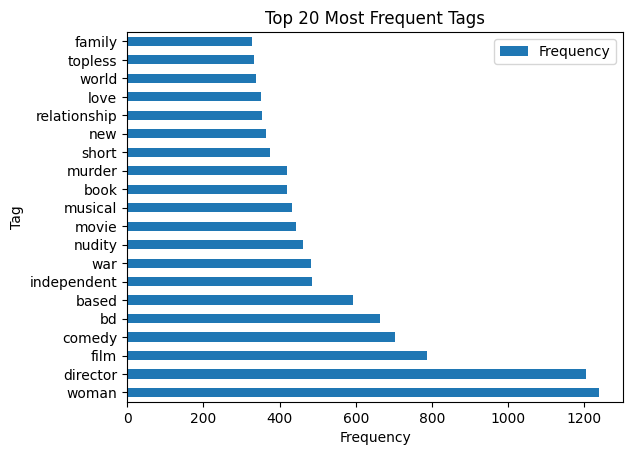

<Figure size 1000x600 with 0 Axes>

C:\Users\João\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\João\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\João\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\João\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


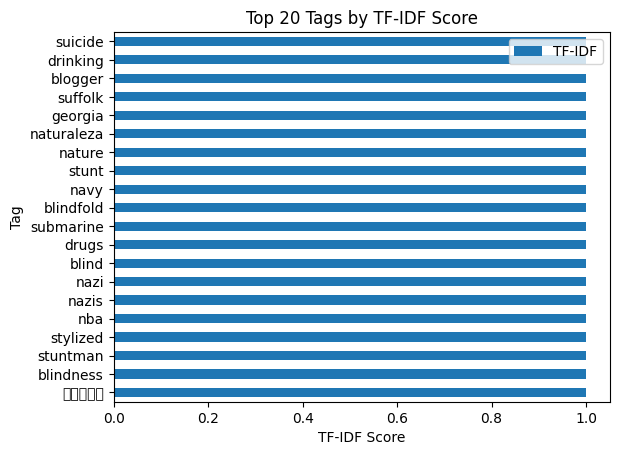

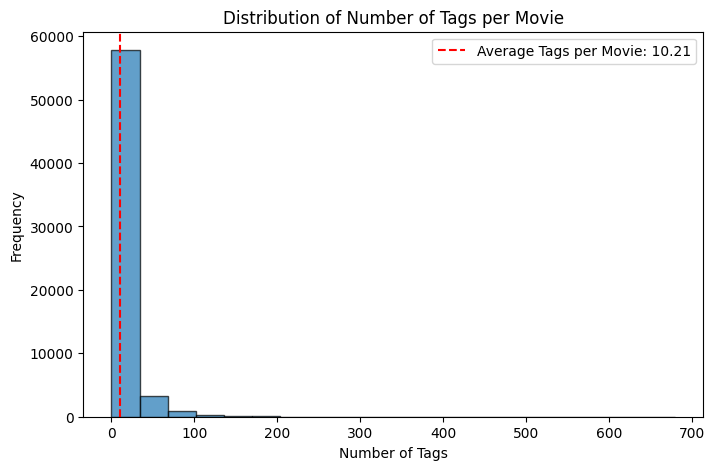

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names from the TF-IDF vectorizer's vocabulary
feature_names = np.array(tfidf.get_feature_names_out())

# Calculate tag frequencies
tag_frequencies = np.array(tfidf_matrix.sum(axis=0)).flatten()
tag_counts = pd.DataFrame(tag_frequencies, index=feature_names, columns=['Frequency'])
tag_counts = tag_counts.sort_values(by='Frequency', ascending=False)

# Plot tag frequencies
plt.figure(figsize=(10, 6))
tag_counts.head(20).plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.title('Top 20 Most Frequent Tags')
plt.show()

# Analyze TF-IDF scores
tag_tfidf_scores = pd.DataFrame(tfidf_matrix.max(axis=0).toarray().flatten(), index=feature_names, columns=['TF-IDF'])
tag_tfidf_scores = tag_tfidf_scores.sort_values(by='TF-IDF', ascending=False)

# Plot TF-IDF scores
plt.figure(figsize=(10, 6))
tag_tfidf_scores.head(20).plot(kind='barh')
plt.xlabel('TF-IDF Score')
plt.ylabel('Tag')
plt.title('Top 20 Tags by TF-IDF Score')
plt.show()

# Analyze movie-tag relationships
movies['num_tags'] = (tfidf_matrix != 0).sum(axis=1)
average_num_tags = movies['num_tags'].mean()

# Plot distribution of number of tags per movie
plt.figure(figsize=(8, 5))
plt.hist(movies['num_tags'], bins=20, edgecolor='k', alpha=0.7)
plt.axvline(x=average_num_tags, color='red', linestyle='--', label=f'Average Tags per Movie: {average_num_tags:.2f}')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tags per Movie')
plt.legend()
plt.show()


## Collaborative/Social


In [14]:
#create utility matrix
def create_umatrix(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_umatrix(ratings_df)

print(X.shape)




# user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')
# user_item_matrix.fillna(0, inplace=True)

# print(user_item_matrix.head())


(610, 9436)


In [ ]:
def collaborative_filtering_recommendation(user_id, X, user_mapper, movie_inv_mapper, num_recommendations=10):
    # Get the index of the user in the matrix
    user_index = user_mapper[user_id]

    # Compute similarity between the target user and all other users
    similarities = cosine_similarity(X[user_index], X)

    # Get indices of most similar users (excluding the user itself)
    similar_users_indices = similarities.argsort()[0][-num_recommendations-1:-1][::-1]

    # Initialize a dictionary to store recommended movies and their scores
    recommended_movies = {}

    # Loop through similar users and their rated movies to recommend
    for similar_user_index in similar_users_indices:
        # Get movies rated by similar user but not by target user
        unrated_movies = np.where(np.logical_and(X[user_index].toarray()[0] == 0, X[similar_user_index].toarray()[0] != 0))[0]
        
        # Compute the score for each unrated movie based on similarity and rating
        for movie_index in unrated_movies:
            if movie_index not in recommended_movies:
                recommended_movies[movie_index] = similarities[0, similar_user_index] * X[similar_user_index, movie_index]
            else:
                recommended_movies[movie_index] += similarities[0, similar_user_index] * X[similar_user_index, movie_index]

    # Sort recommended movies by score in descending order
    recommended_movies = sorted(recommended_movies.items(), key=lambda x: x[1], reverse=True)

    # Get the movie ids of the recommended movies
    recommended_movie_ids = [movie_inv_mapper[movie_index] for movie_index, _ in recommended_movies]

    return recommended_movie_ids[:num_recommendations]

# Example usage
user_id = 1
num_recommendations = 10
recommendations = collaborative_filtering_recommendation(user_id, X, user_mapper, movie_inv_mapper, num_recommendations)
print("Recommended Movies for User", user_id, ":")
for movie_id in recommendations:

    print(f"{movie_id} with title {movies_df['title'].iloc[movie_id]}")

In [18]:
def recommend_movies(user_id, X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper, k, metric='cosine', n_recommendations=10):
    # Map user_id to matrix index
    user_idx = user_mapper[user_id]

    # Fit KNN model
    knn = NearestNeighbors(metric=metric, algorithm='auto')
    knn.fit(X)

    # Find k nearest neighbors
    distances, indices = knn.kneighbors(X[user_idx], n_neighbors=k+1)
    
    # Remove the input user itself
    distances = distances.flatten()
    indices = indices.flatten()
    
    neighbors_indices = indices[1:]  # exclude the first one as it is the user itself
    distances = distances[1:]

    # Collect movie recommendations
    all_recommended_movies = []
    for neighbor_idx in neighbors_indices:
        neighbor_ratings = X[neighbor_idx].toarray().flatten()
        recommended_movies = np.where(neighbor_ratings > 0)[0]
        all_recommended_movies.extend(recommended_movies)
    
    # Convert matrix indices to movie IDs
    recommended_movie_ids = [movie_inv_mapper[movie_idx] for movie_idx in all_recommended_movies]
    
    # Filter out movies the user has already rated
    user_rated_movies = set(np.where(X[user_idx].toarray().flatten() > 0)[0])
    recommended_movie_ids = [movie_id for movie_id in recommended_movie_ids if movie_mapper[movie_id] not in user_rated_movies]
    
    # Rank movies by the frequency they appear in the neighbors' lists
    movie_counts = Counter(recommended_movie_ids)
    ranked_recommendations = [movie for movie, _ in movie_counts.most_common(n_recommendations)]
    
    return ranked_recommendations

# Example usage
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_umatrix(ratings_df)

user_id = 1  # Replace with the actual user ID you want to recommend for
k = 5  # Number of neighbors
metric = 'cosine'  # Distance metric
n_recommendations = 10  # Number of recommendations to return

recommended_movies = recommend_movies(user_id, X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper, k, metric, n_recommendations)
print(f"Recommended movies for user {user_id}: {recommended_movies}")

Recommended movies for user 1: [377, 474, 589, 924, 1036, 1200, 1374, 1375, 1610, 1968]
